<a href="https://colab.research.google.com/github/jagrutimohanty/CrossDomain-Realtime-FineGrained-Twitter-Senitment-Analysis/blob/main/Take_the_Pulse_Demoshown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

DIR = '/content/drive/Shareddrives/255/Project'
if os.getcwd() != DIR:
  os.chdir(DIR)

Mounted at /content/drive


# **TAKE THE PULSE - DEMO**

## **Fine Grained Sentiment Analysis with Twitter**

For our demo we'll showcase our model's predictions in two ways, offline sentiment analysis prediction as well as realtime predictions

## Offline Analysis
We'll do this in five steps
* fetch tweets about movie hashtags from the Twitter API. 
* run the tweets through a preprocessing pipeline
* encode them using BERT like we did for our training data
* pass them through our best performing model to get predictions
* present the predictions on a bar graph

### Step 1: Fetching the Tweets

In [ ]:
import tweepy
import pandas as pd
import numpy as np

In [ ]:
# consumer_key = ''
consumer_key = ''
# consumer_secret = ''
consumer_secret = ''
# access_token = ''
access_token =  ''
# access_token_secret = ''
access_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key,consumer_secret) 
auth.set_access_token(access_token, access_token_secret) 
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [ ]:
# FYI, there's a rate limiter on this API call, when we hit the rate limit, the
# function sleeps for a set amount of time
from datetime import datetime, timedelta

now=datetime.today().now()
prev=now-timedelta(days=150)
now=now.strftime("%Y-%m-%d")
prev=prev.strftime("%Y-%m-%d") 
# LockHerUp negative sentiments
# hamilton, TGIF positive sentiments
# MacbookAir, iphone12, MacMini, MacOSBigSur for product sentiment
# iphone12ProMax, GalaxyS20Ultra, Pixel4XL
tweetObjects = tweepy.Cursor(
    api.search, 
    q=['#iphone12'], 
    lang="en", 
    since=prev,
    until=now, 
    result_type="recent",
    tweet_mode='extended'
    ).items(2000)
tweets_df = pd.DataFrame([tweetObj.full_text for tweetObj in tweetObjects], columns=['text'])

For the purposes of our demo we saved the tweets onto Google drive because this API call is rate limited, we don't want to keep fetching the same tweets over and over again and hit the rate limit

In [ ]:
tweets_df.to_csv('./tweets/MacbookAir.csv', index=False)

In [ ]:
pd.set_option('display.max_colwidth', -1)
tweets_df.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,text
900,RT @MarkhorTechUrdu: The unboxing of very first Macbook air with Apple M1 chip #m1Chip @apple #MacBookAir https://t.co/8fVfQJVKw0
862,"RT @Poorvika_Mobile: Experience Power that's in the Air with the 13.3"" #MacBookAir from #Apple available for just ₹72,990 with ₹6,000 #HDFC…"
57,Just noticed that every time I hit the #shuffle button in #AppleMusic on a #MacBookPro or #MacBookAir it just plays first track then normal play. It highlights shuffle but doesn’t actually #shuffle @Apple @AppleSupport
277,DONATIONS ARE DOUBLED TODAY!! #GivingTuesday #AdventCalendar #distancelearning #disney #Apple #macbookair #December1st Check out my classroom on @DonorsChoose! I'd love your help to bring my project to life: https://t.co/DqIxnxizX7
167,"@Apple analyst Ming-Chi Kuo believes that as part of Apple's mini LED push, the company will release a pair of new #MacBookPro models in 2021 with the technology — and a ""more affordable"" #MacBookAir in 2022. @appleinsider @Mike_Wuerthele \nhttps://t.co/Fr6zOjkYPK"


### Step 2: Tweets Preprocessing

We remove all links since they wont add any semantic value to the encoding, we also remove the hashtags and the @mentions as well as the 'RTs' for retweets

Input Tweet Text
<br>
>`@DaveedDiggs @annas_tea_ I shall Daveed! Just because you asked and were so INCREDIBLE in #Hamilton #BOOM my… https://t.co/0Ccg3Tu9KD`
<br> 

Preprocessed Tweet text
<br>
>`tea i shall daveed just because you asked and were so incredible in my` 
<br>


In [ ]:
import re,string

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    text = ' '.join(words)
    return text.replace('RT ', '').lower()

def preprocess_tweets(s):
  return strip_all_entities(strip_links(s))

tweets_df['text'] = tweets_df ['text'].apply(preprocess_tweets)

We also remove tweets that are only punctuations

In [ ]:
remove_invalid_phrases = lambda s: s.strip(string.punctuation) != ''
tweets_df = tweets_df[tweets_df['text'].apply(remove_invalid_phrases).to_list()]

We might have tweets that have no text after all our pre-processing, so let's filter out such tweets if any

In [ ]:
tweets_df = tweets_df[tweets_df['text'] != '']
tweets_df.shape

(2000, 1)

### Step 3: Tweets BERT Encoding

We now run the cleaned tweets through a Sentence Bert encoder. We use a publicly available pretrained model. `distilbert-base-nli-stsb-mean-tokens`, that is based on the paper *Sentence Embeddings using Siamese BERT Networks* by Nils Reimer and Iryna Gurevyh https://arxiv.org/abs/1908.10084

Sentence BERT outputs a vector of shape (768,) for each tweet

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 1.3MB 8.5MB/s 
     |████████████████████████████████| 2.9MB 41.4MB/s 
     |████████████████████████████████| 1.1MB 43.9MB/s 
     |████████████████████████████████| 890kB 34.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101036 sha256=78056648d7d18269bbb7d4363c6508e93e01dbbf5ccc670a69f041e19de92327
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e6788d090f57a169b607a12d69fe0a549942cbd89d8bbb6961adbcdb685fd23f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
encodings = sbert_model.encode(tweets_df['text'].to_numpy())

100%|██████████| 405M/405M [00:18<00:00, 22.4MB/s]


### Step 4: Predict the sentiment aka "Take the Pulse"

We'll load our best performing SVM Classfier and predict the sentiment of the tweets.

> This classifier does include a scikit learn standard scaler in its pipeline that normalizes the vectors before making predictions



In [ ]:
from joblib import load
# clf = load('./svm_models/rbf_512_80000_5.joblib')
# balanced classifier that takes into account the imbalance in our dataset
clf = load('./svm_models/rbf_80000_5_balanced.joblib')
ovr_clf = load('./svm_models/ovr_rbf_80000_5_balanced.joblib')
gcv_clf = load('./svm_models/rbf_80000_5_balanced_gcv.joblib')

We'll apply PCA to our tweet encoding vectors, by reducing it to a vector of shape (512,) for consistency with how our model was trained. This allows us to speed up the prediction while keeping over 99% of the variance in the original encodings array.

>We don't need to apply standard sacling here since it's included as part of the pipelined classifier that we loaded into memory

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)
encodings = pca.fit_transform(encodings)
print(np.sum(pca.explained_variance_ratio_))

1.0


In [ ]:
tweets_df.shape

(2000, 1)

In [ ]:
sentiments = clf.predict(encodings)
ovr_sentiments = ovr_clf.predict(encodings)
gcv_sentiments = gcv_clf.predict(encodings)
tweets_df = tweets_df.assign(sentiments=sentiments)
tweets_df = tweets_df.assign(ovr_sentiments=ovr_sentiments)
tweets_df = tweets_df.assign(gcv_sentiments=gcv_sentiments)

In [ ]:
tweets_df.sample(5)

### Step 5: Visualization

Map from label numbers to sentiment description

In [ ]:
labels_map = {
    '0': 'Very Negative :(',
    '1': '- Negative -',
    '2': 'Neutral :-|',
    '3': '+ Positive +',
    '4': 'Very Positive :)'
}

In [ ]:
import matplotlib.pyplot as plt

counts = tweets_df['sentiments'].value_counts()
x = [labels_map[str(idx)] for idx in counts.index]
y = counts.to_numpy()
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(x,y)
plt.show()

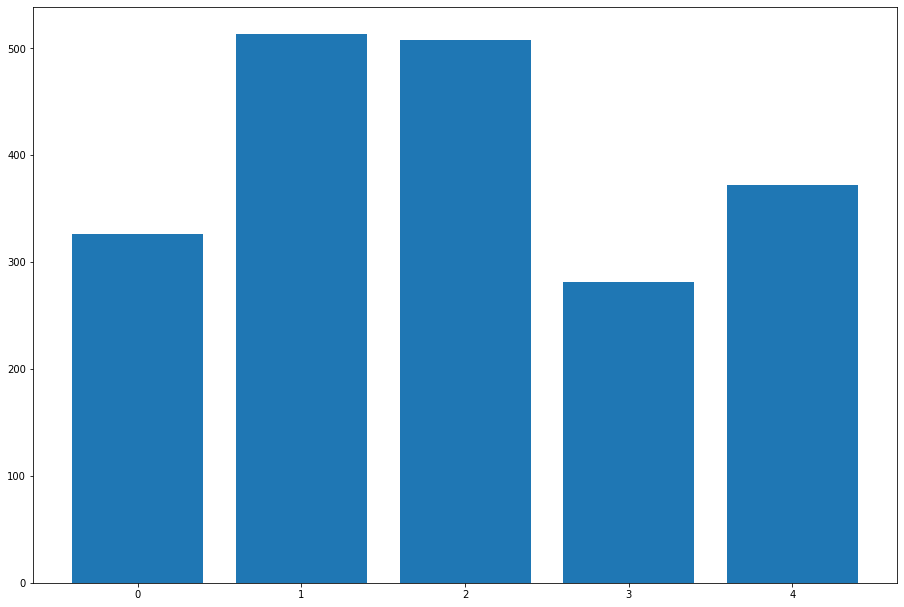

In [ ]:
x = counts.index
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.bar(x,y)
plt.show()

For multiple hashtags we can display the same information on a stacked bar graph.

## Online Analysis 

### Streaming Tweets

We can also stream tweets from trending topics and get predictions on the sentiment of these tweets. So this runs through essentially the same pipeline as above, except the tweets are not obtained in a single REST API call but through a streaming API that listens until it reaches a minimum number of tweets and then runs the sentiment analysis pipeline with predictions at the end.

In [ ]:
# helper function to preprocess and predict the sentiment for a single tweet
def take_the_pulse(tweet):
  tweets = [tweet]
  tweets = list(map(preprocess_tweets, tweets))
  tweets = list(filter(remove_invalid_phrases, tweets))
  encodings = sbert_model.encode(tweets)
  sentiments = u_clf.predict(pca.transform(encodings))
  return tweets[0], sentiments[0]

In [ ]:
# helper function to get tweet's full text
def get_full_text(tweet):
    if 'retweeted_status' in tweet and 'extended_tweet' in tweet['retweeted_status']:
        return tweet['retweeted_status']['extended_tweet']['full_text']
    if 'extended_tweet' in tweet:
        return tweet['extended_tweet']['full_text']
    else:
        return tweet['text']

In [ ]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import re
import json

# Global variables to keep track of when to close the stream
tweet_count = 0
MAX_TWEET_COUNT = 3

# Tweet Stream Listener
class StdOutListener(StreamListener):  
    def on_data(self, data):
        global tweet_count
        global MAX_TWEETS
        global stream
        if tweet_count < MAX_TWEET_COUNT:
            tweet = json.loads(data)    
            if tweet['lang'] == "en":
              text = get_full_text(tweet)
              processed_text, sentiment = take_the_pulse(text)
              print('==================================================')
              print('Tweet: ', processed_text)
              print('Predicted Sentiment: ', labels_map[str(sentiment)])
              print('==================================================')
              tweet_count += 1
            return True
        else:
            stream.disconnect()

In [ ]:
# Handles Twitter authetification and the connection to Twitter Streaming API
tweet_count = 0
listener = StdOutListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
stream = Stream(auth, listener, tweet_mode='extended')
stream.filter(track=['#COVID19'])

### Trending Topics

We'll try out our model with trending topics and see what results we get

Fetch trending topics by location. For this cell we'll experiment with ID 1 which is the global ID for trending topics worldwide

In [ ]:
# get tags by location
# we'll use ID 1 and ID 2488042 
GLOBAL_ID = 1
SJ_ID = 2488042
SF_ID = 2487956
tags = api.trends_place(GLOBAL_ID)

def top_k_tags(k, tags):
  top_k = tags[0]['trends'][:k]
  return [(tag['name'], tag['query'], tag['tweet_volume']) for tag in top_k]

Get the top 10 topics and their corresponding tweet volume

In [ ]:
top10 = top_k_tags(10, tags)
print(top10)

[('#WeLoveYouHyunjin', '%23WeLoveYouHyunjin', 105749), ('#HyunjinBestBoy', '%23HyunjinBestBoy', 98435), ('#REUNION', '%23REUNION', 17223), ('#ガチで欲しいもの5選', '%23%E3%82%AC%E3%83%81%E3%81%A7%E6%AC%B2%E3%81%97%E3%81%84%E3%82%82%E3%81%AE5%E9%81%B8', None), ('#RESONANCEwithNCT', '%23RESONANCEwithNCT', 158587), ('集計ミス', '%E9%9B%86%E8%A8%88%E3%83%9F%E3%82%B9', 10220), ('リンボマン', '%E3%83%AA%E3%83%B3%E3%83%9C%E3%83%9E%E3%83%B3', 17890), ('BTS vs BTS', '%22BTS+vs+BTS%22', 56844), ('soobin', 'soobin', 141159), ('محمد', '%D9%85%D8%AD%D9%85%D8%AF', 387472)]


In [ ]:
hottest_topic_query = top10[0][0]
if hottest_topic_query[0] != '#':
  hottest_topic_query = '#' + hottest_topic_query
hottest_topic_query

'#WeLoveYouHyunjin'

Set a stream to listen in for the tweets and predict their sentiment as they come in.

In [ ]:
tweet_count = 0
listener = StdOutListener()
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
stream = Stream(auth, listener, tweet_mode='extended')
stream.filter(track=[hottest_topic_query])